## Multiclass Classification
### First method: k-nearest neighbours (kNN)
### Second method: Logistic Regression + gradient descent

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import unittest

### Data generatar

In [13]:
# all data
def standard_data_generator(N):
    return [random_data(1.5, 0.3, N), random_data(1.5, 0.55, N), 
            random_data(0.5, 0.45, N), random_data(1.5, 0.45, N),
            random_data(0.5, 0.55, N), random_data(0.5, 0.35, N),
            random_data(1.5, 0.45, N), random_data(0.5, 0.2, N)]
    
def random_data(a, rng, N):
    data = np.random.uniform(a - rng, a + rng, size = N)
    return np.array([[d] for d in data])

### How does the data actually look like

[[1.57353039]
 [1.39409266]
 [1.34648696]
 [1.20688933]
 [1.55663153]
 [1.38099927]
 [1.40670311]
 [1.58827074]
 [1.32512214]
 [1.45176198]
 [1.2244781 ]
 [1.66728404]
 [1.29228996]
 [1.65764092]
 [1.35085835]]
[[0.66918102]
 [0.88025716]
 [0.58618434]
 [0.25692916]
 [0.7227338 ]
 [0.19604096]
 [0.87050369]
 [0.56132113]
 [0.41754905]
 [0.23008956]
 [0.78302892]
 [0.52383668]
 [0.76198971]
 [0.61131407]
 [0.54579463]]
[[ 0.52840837]
 [ 0.35891058]
 [ 0.6191233 ]
 [ 0.94668138]
 [ 0.9645105 ]
 [ 0.8756351 ]
 [ 0.63987188]
 [ 0.67754686]
 [ 0.1696132 ]
 [ 0.64114303]
 [-0.03640748]
 [ 0.48552613]
 [ 0.23287682]
 [ 0.62246888]
 [ 0.90476542]]
[[1.93007043]
 [1.41303773]
 [1.85162494]
 [1.67687033]
 [1.60543099]
 [1.54054357]
 [1.19643205]
 [1.63353012]
 [1.46164293]
 [1.40854106]
 [1.05986052]
 [1.77545227]
 [1.70111129]
 [1.93482043]
 [1.31185762]]
[[1.19514938]
 [1.84615784]
 [1.96379675]
 [1.80001768]
 [1.30982413]
 [1.41815403]
 [1.96207359]
 [1.34754053]
 [1.17595645]
 [1.8340473 ]
 

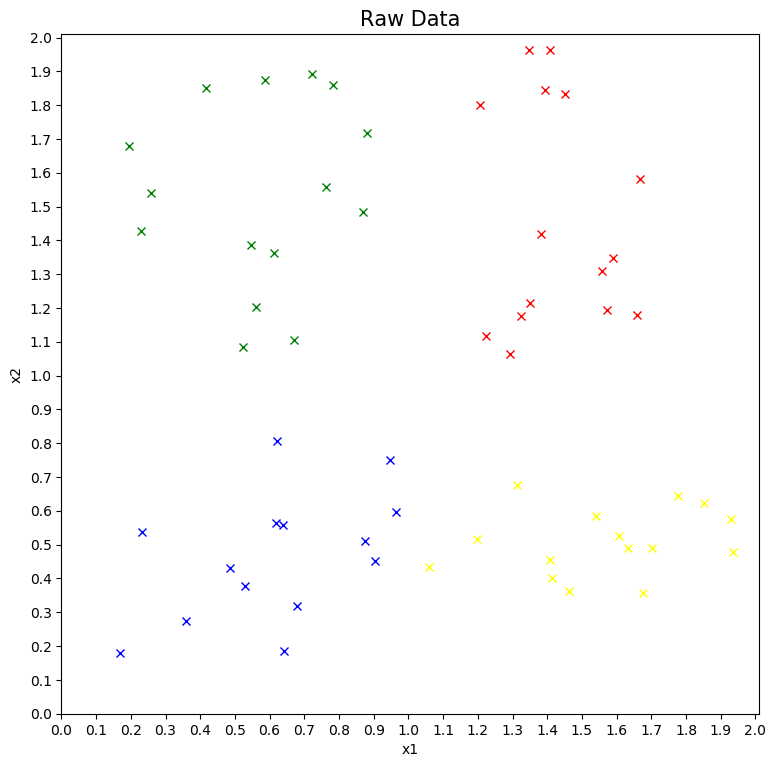

In [29]:
# settings
x_min = 0
x_max = 2.01
y_min = 0
y_max = 2.01
period = 0.1

# graph settings
plt.figure(figsize=(9,9), dpi=100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min, y_max)
plt.xticks(np.arange(x_min, x_max, period))
plt.yticks(np.arange(y_min, y_max, period))
plt.xlabel("x1", fontsize=10)
plt.ylabel("x2", fontsize=10)

# raw data call:
data = standard_data_generator(15)
print(data[0])
print(data[2])
print(data[4])
print(data[6])
print(data[1])
print(data[3])
print(data[5])
print(data[7])
#complete_data = np.concatenate([dt for dt in data[0:2:]])
print(np.concatenate()
plt.plot(data[0],data[1], 'x', color='red')
plt.plot(data[2],data[3], 'x', color='green')
plt.plot(data[4],data[5], 'x', color = 'blue')
plt.plot(data[6],data[7], 'x', color = 'yellow')

# showing resluts
plt.title("Raw Data", fontsize = 15)
plt.show()

### k-Nearest Neighbours

In [ ]:
class KnnModel(class)
    def __init__(self):
        self.best_k = -1

    def learn_algorithm(self, train_data, val_data):
        self.__knn_model_selection(train_data, val_data)
        
        srt = sort_train_labels_knn(hamming_distance(X_val, X_train), y_train)
        errs = [classification_error(p_y_x_knn(srt, k), y_val) for k in k_values]
        return min(errs), k_values[errs.index(min(errs))], errs
    
    def __calculate_distance(self, x_val, y_val, x_train, y_train):
        pass

    def __sort_closest_distances(self):
        pass

    def __calculate_distribution_knn(self):
        pass

    def __knn_model_selection(self, x_val, y_val, x_train, y_train):
        distances = self.__calculate_distance(x_val, y_val, x_train, y_train)
        srt = sort_train_labels_knn(distances, y_train)

### Logistic Regression + gradient descent

In [ ]:
# TODO

# Unittests

In [12]:
x_val = np.array([[1],[1],[2],[2],[3]])
y_val = np.array([[2],[2],[4],[4],[6]])
x_train = np.array([[3],[2],[1],[1],[0]])
y_train = np.array([[6],[4],[2],[2],[0]])

class KnnTests(unittest.TestCase):
    
    def test_calculate_distance(self):
        answer = calculate_distance(x_val, x_train)
        expected = 1
        self.assertEqual(expected.tolist(), answer.tolist())
        
    def test_sort_closest_distances(self):
        pass
    
    def test_calculate_distribution_knn(self):
        pass

In [4]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_1 (__main__.KnnTests) ... ERROR

ERROR: test_1 (__main__.KnnTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-3-6294ba558b01>", line 6, in test_1
    self.assertEqual(expected.tolist(), answer.tolist())
AttributeError: 'int' object has no attribute 'tolist'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)
